<a href="https://colab.research.google.com/github/LINKON200030/Brain-Tumor-Detection-CNN-Model/blob/main/Brain_Tumar_Detection_Model_(4_Classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub -q # Install kaggle dataset system in python

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import kagglehub #Helps to connect it from orginal kaggle database

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Conncect kaggle dataset in Colab. Orginal links of dataset- https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# Checking Dataset Structure
for root, dirs, files in os.walk(path):
    print(root, "->", len(files), "files")


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
/kaggle/input/brain-tumor-mri-dataset -> 0 files
/kaggle/input/brain-tumor-mri-dataset/Training -> 0 files
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary -> 1457 files
/kaggle/input/brain-tumor-mri-dataset/Training/notumor -> 1595 files
/kaggle/input/brain-tumor-mri-dataset/Training/meningioma -> 1339 files
/kaggle/input/brain-tumor-mri-dataset/Training/glioma -> 1321 files
/kaggle/input/brain-tumor-mri-dataset/Testing -> 0 files
/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary -> 300 files
/kaggle/input/brain-tumor-mri-dataset/Testing/notumor -> 405 files
/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma -> 306 files
/kaggle/input/brain-tumor-mri-dataset/Testing/glioma -> 300 files


In [ ]:
# Joining dataset with model
train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")

print("Train dir:", train_dir)
print("Test dir:", test_dir)
print("Train classes:", os.listdir(train_dir))
print("Test classes:", os.listdir(test_dir))


Sample from: /kaggle/input/brain-tumor-mri-dataset/Training/pituitary


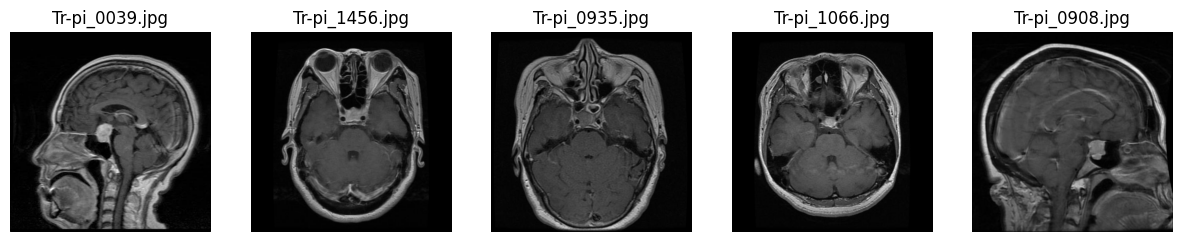

Sample from: /kaggle/input/brain-tumor-mri-dataset/Training/glioma


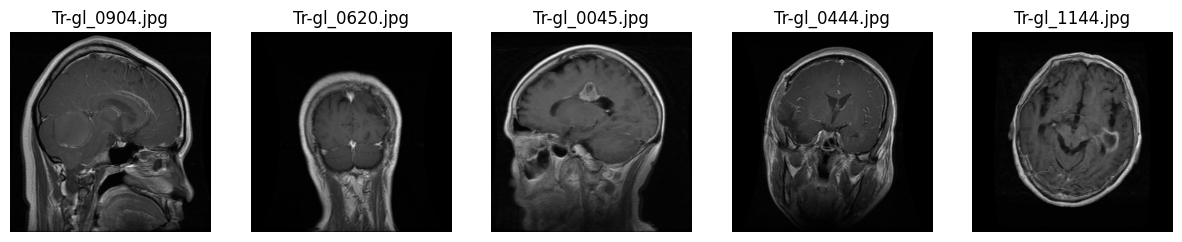

In [ ]:
# Testing file structure connection with getting randome picture
def show_random_images(folder, n=5):
    imgs = os.listdir(folder)
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img_name = np.random.choice(imgs)
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis('off')
    plt.show()

# For testing I choose two types, Glioma and no_tumor. [0] means first folder and [-1] defined lasr folder
glioma_folder   = os.path.join(train_dir, os.listdir(train_dir)[0])  # choose first class
no_tumor_folder = os.path.join(train_dir, os.listdir(train_dir)[-1]) # choose last class

# Here n=5 is a random number which identify how many picture need to be randomly choosed.

print("Sample from:", glioma_folder) # Visulaise sample test
show_random_images(glioma_folder, n=5)

print("Sample from:", no_tumor_folder)# Visualise sample test
show_random_images(no_tumor_folder, n=5)


In [ ]:

#Resized the datasets image resulation in one common resulation.

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2      # 80% train, 20% val from Training folder
)

# Training subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # one-hot labels (4 classes)
    subset='training'
)

# Validation subset
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test data (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False   # important for confusion matrix
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Class indices:", class_indices)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu',
                  input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 4 (optional extra depth)
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    # Output layer: 4 classes → softmax
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,600,964 (13.74 MB)

 Trainable params: 3,600,964 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # multi-class classification
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 15  # Choose number of EPOCHS 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 418ms/step - accuracy: 0.4568 - loss: 1.1205 - val_accuracy: 0.6301 - val_loss: 0.9437
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - accuracy: 0.7068 - loss: 0.6823 - val_accuracy: 0.6801 - val_loss: 0.7869
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.7845 - loss: 0.5404 - val_accuracy: 0.7029 - val_loss: 0.7709
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 277ms/step - accuracy: 0.8026 - loss: 0.4933 - val_accuracy: 0.7344 - val_loss: 0.6840
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - accuracy: 0.8225 - loss: 0.4453 - val_accuracy: 0.7511 - val_loss: 0.7095
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.8579 - loss: 0.3784 - val_accuracy: 0.7713 - val_loss: 0.5477
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 281ms/step - accuracy: 0.8687 - loss: 0.3474 - val_accuracy: 0.7713 - val_loss: 0.6090
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.8786 - loss: 0

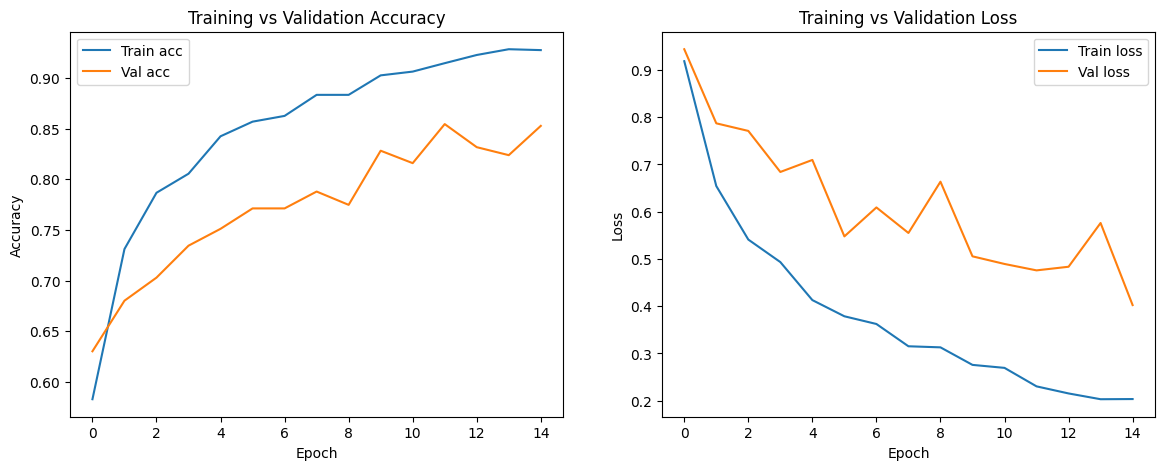

In [ ]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8147 - loss: 0.4450
Test Loss: 0.296033650636673
Test Accuracy: 0.8840579986572266


In [ ]:
# Predictions for each test image
test_generator.reset()
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())
print("Class labels:", class_labels)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']
Confusion Matrix:
 [[241  38  11  10]
 [  6 221  64  15]
 [  0   0 405   0]
 [  1   1   6 292]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.80      0.88       300
  meningioma       0.85      0.72      0.78       306
     notumor       0.83      1.00      0.91       405
   pituitary       0.92      0.97      0.95       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.89      0.88      0.88      1311



In [ ]:
model.save("brain_tumor_cnn_kagglehub_4class.h5")


Testing image: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0068.jpg


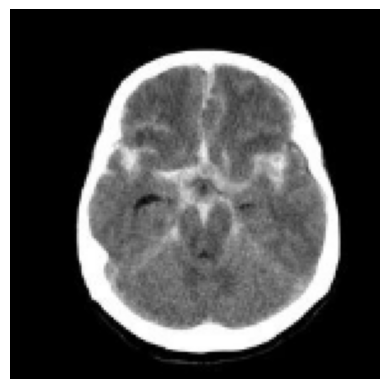

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted class: notumor
Probabilities: [2.5421796e-06 1.1941167e-03 9.9880338e-01 5.8387601e-09]


In [ ]:
# Test the model

def predict_single_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)

    plt.imshow(img_resized)
    plt.axis('off')
    plt.show()

    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_prob = model.predict(img_array)[0]
    pred_class = np.argmax(pred_prob)

    print("Predicted class:", class_labels[pred_class])
    print("Probabilities:", pred_prob)

# Example: choose one image from Testing/glioma_tumor
example_class = class_labels[2]  # e.g. 'glioma_tumor'
example_folder = os.path.join(test_dir, example_class)
example_image = np.random.choice(os.listdir(example_folder))
example_path = os.path.join(example_folder, example_image)

print("Testing image:", example_path)
predict_single_image(example_path)
